# Práctico: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [ ]:
# Importacion de librerias y descarga de datos.

import pandas as pd
import seaborn
import sys
import datetime as dt

in_colab = 'google.colab' in sys.modules

if in_colab:
  !echo "** INSTALLING SURPRISE **"
  !pip install scikit-surprise

  !echo -e "\n** DOWNLOADING FILES **"
  !rm -rf data/lastfm/
  !mkdir -p data/lastfm/
  !curl -LO http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip
  !unzip hetrec2011-lastfm-2k.zip -d data/lastfm/
  !rm -f hetrec2011-lastfm-2k.zip

  DS_FILEPATH = "data/lastfm/"
else: 
  DS_FILEPATH = "../data/lastfm/"

print("\n** IMPORT SURPRISE **")
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise import accuracy
from surprise.accuracy import rmse

from sklearn.metrics.pairwise import cosine_similarity

print(f"Surpr!se version: {surprise.__version__} imported")

import matplotlib.pyplot as plt
import numpy as np

** INSTALLING SURPRISE **
     |████████████████████████████████| 11.8MB 273kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618289 sha256=62be0a14bdfb9ea27addd9f8ab23bf82be7c94189871efdfe6c8d4d224bcc5be
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise

** DOWNLOADING FILES **
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2528k  100 2528k    0     0  1273k      0  0:00:01  0:00:01 --:--:-- 1272k
Archive:  hetrec2011-lastfm-2k.zip
  inflating: data/lastfm/user_friends.dat  
  inflating: data/lastfm/user_taggedartists.dat  
  inflating: data/lastfm/user_taggedartists-timestamps.dat  
  inflating: data/lastfm/artists.dat  
  inflating: data/lastfm/readme.txt  
  inflating: data/lastfm/tags.dat    
  inflating: data/lastfm/use

In [ ]:
ds_artist_data = pd.read_csv(DS_FILEPATH + "artists.dat", sep="\t", usecols=['id','name'])
ds_artist_data.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [ ]:
ds_artist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17632 non-null  int64 
 1   name    17632 non-null  object
dtypes: int64(1), object(1)
memory usage: 275.6+ KB


In [ ]:
ds_user_artist_plays = pd.read_csv(DS_FILEPATH + "user_artists.dat", sep="\t")
ds_user_artist_plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [ ]:
ds_user_artist_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB


## Actividades

El [Ejercicio 1](#Ejercicio-1---Análisis-Exploratorio-de-Datos) deberá ser realizado por quienes estén realizando cualquier parte de la materia.

El [Ejercicio 2](#Ejercicio-2---Sistema-de-Recomendación) variará de acuerdo a que parte de la materia estén realizando, quienes estén realizando la materia completa, deberán realizar ambas partes.

De acuerdo a la parte de la materia que hagan, deberán realizar una de las siguientes actividades (pueden realizar ambas si así lo desean):

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar dos sistemas de recomendación: 
1. El primero, más sencillo, utilizando [Surpr!se](http://surpriselib.com/), y a partir de los datos de LastFM, en especial del archivo `./data/lastfm/user_artists.dat`, generar un sistema de recomendación basado en filtros colaborativos.
2. En el segundo, deberán utilizar todos los datos ofrecidos en el dataset de LastFM para generar un sistema de filtrado colaborativo más complejo, deberá utilizar las técnicas aprendidas 

basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [ ]:
print("Cantidad de filas en los datasets")
print("artist_data:       {}".format(ds_artist_data.shape[0]))
print("user_artist_plays: {}\n".format(ds_user_artist_plays.shape[0]))

print("Columnas")
print("artist_data:       {}".format(ds_artist_data.columns))
print("user_artist_plays: {}\n".format(ds_user_artist_plays.columns))

print("weight min: {}, weight max {}".format(ds_user_artist_plays.weight.min(), ds_user_artist_plays.weight.max()))

Cantidad de filas en los datasets
artist_data:       17632
user_artist_plays: 92834

Columnas
artist_data:       Index(['id', 'name'], dtype='object')
user_artist_plays: Index(['userID', 'artistID', 'weight'], dtype='object')

weight min: 1, weight max 352698


In [ ]:
# moda de artistas escuchados
ds_artist_data.loc[ds_artist_data['id'] == ds_user_artist_plays.artistID.mode()[0]]

,id,name
83,89,Lady Gaga


In [ ]:
# Union de los datasets
ds_artist_plays = pd.merge(ds_user_artist_plays, ds_artist_data,
                        how="inner",
                        left_on="artistID",
                        right_on="id")

del ds_artist_plays['id']
ds_artist_plays = ds_artist_plays.rename(columns={'name': 'artistName', 'weight': 'playCounts'})
ds_artist_plays

,userID,artistID,playCounts,artistName
0,2,51,13883,Duran Duran
1,4,51,228,Duran Duran
2,27,51,85,Duran Duran
3,28,51,10,Duran Duran
4,62,51,528,Duran Duran
...,...,...,...,...
92829,2100,18726,337,Nyktalgia
92830,2100,18727,297,Atsakau niekadA
92831,2100,18728,281,Domantas Razauskas
92832,2100,18729,280,Atalyja


In [ ]:
# Vemos si los usuarios aparecen mas de una vez en el dataset
ds_artist_plays.userID.value_counts().reset_index()

,index,userID
0,2047,50
1,1749,50
2,917,50
3,981,50
4,1109,50
...,...,...
1887,1603,1
1888,1731,1
1889,1307,1
1890,1758,1


In [ ]:
# vemos información y que no haya valores nulos en el dataset
ds_artist_plays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92834 entries, 0 to 92833
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userID      92834 non-null  int64 
 1   artistID    92834 non-null  int64 
 2   playCounts  92834 non-null  int64 
 3   artistName  92834 non-null  object
dtypes: int64(3), object(1)
memory usage: 3.5+ MB


In [ ]:
# vemos que pasa si agrupamos por usuario y artistas escuchados para sumar el playCounts

ds_artist_plays_group = ds_artist_plays.groupby(['userID','artistName','artistID']).sum() \
.reset_index().sort_values(by='playCounts',ascending=False)

ds_artist_plays_group.head(10)

,userID,artistName,artistID,playCounts
72751,1642,Depeche Mode,72,352698
91681,2071,Thalía,792,324663
49337,1094,U2,511,320725
84247,1905,Blur,203,257978
73773,1664,Paramore,498,227829
51464,1146,Evanescence,378,203165
23738,514,Christina Aguilera,292,176133
87626,1983,Shakira,701,172496
34726,757,Shakira,701,169596
48913,1086,Glee Cast,679,165902


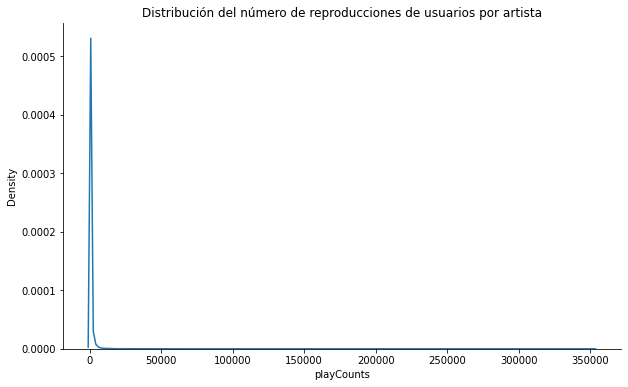

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Distribución del número de reproducciones de usuarios por artista')
seaborn.kdeplot(ds_artist_plays_group.playCounts)
seaborn.despine()

In [ ]:
#Por cantidad de usuarios que los escucharon (no por cantidad de reproduciones)
ds_art_usr = ds_artist_plays_group.artistName.value_counts().rename_axis(["artista"]).rename('oyentes').reset_index()
display(ds_art_usr.head(10))

,artista,oyentes
0,Lady Gaga,611
1,Britney Spears,522
2,Rihanna,484
3,The Beatles,480
4,Katy Perry,473
5,Madonna,429
6,Avril Lavigne,417
7,Christina Aguilera,407
8,Muse,400
9,Paramore,399


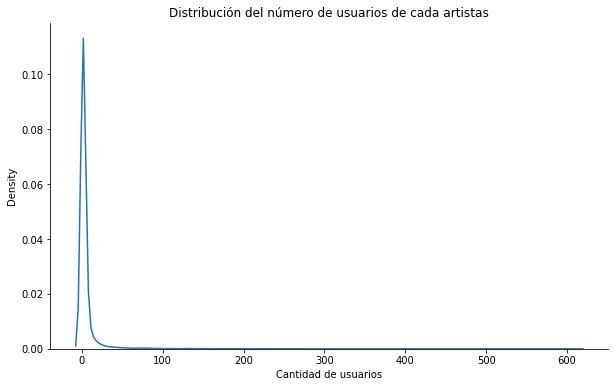

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Distribución del número de usuarios de cada artistas')
plt.xlabel('Cantidad de usuarios')
seaborn.kdeplot(ds_art_usr.oyentes)
seaborn.despine()

In [ ]:
# Por playCounts
ds_art_rep = ds_artist_plays_group.groupby(['artistID','artistName'])['playCounts'].sum().reset_index().sort_values(by='playCounts',ascending=False)
display(ds_art_rep.head(10))

,artistID,artistName,playCounts
283,289,Britney Spears,2393140
66,72,Depeche Mode,1301308
83,89,Lady Gaga,1291387
286,292,Christina Aguilera,1058405
492,498,Paramore,963449
61,67,Madonna,921198
282,288,Rihanna,905423
695,701,Shakira,688529
221,227,The Beatles,662116
294,300,Katy Perry,532545


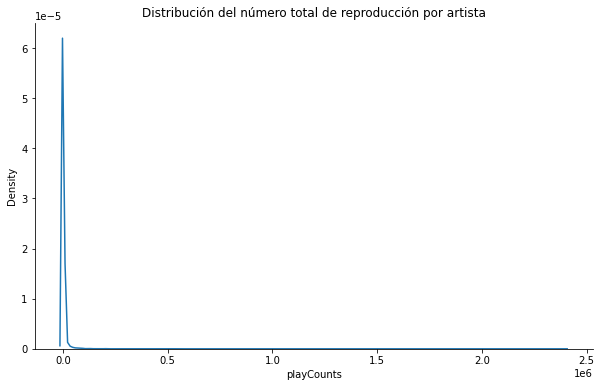

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Distribución del número total de reproducción por artista')
seaborn.kdeplot(ds_art_rep.playCounts)
seaborn.despine()

In [ ]:
# hacemos un análisis descriptivo de los datos
ds_artist_plays_group.describe()

,userID,artistID,playCounts
count,92834.000000,92834.000000,92834.00000
mean,1037.010481,3331.123145,745.24393
std,610.870436,4383.590502,3751.32208
min,2.000000,1.000000,1.00000
25%,502.000000,436.000000,107.00000
50%,1029.000000,1246.000000,260.00000
75%,1568.000000,4350.000000,614.00000
max,2100.000000,18745.000000,352698.00000


Text(0.5, 32.99999999999995, 'Cantidad de usuarios')

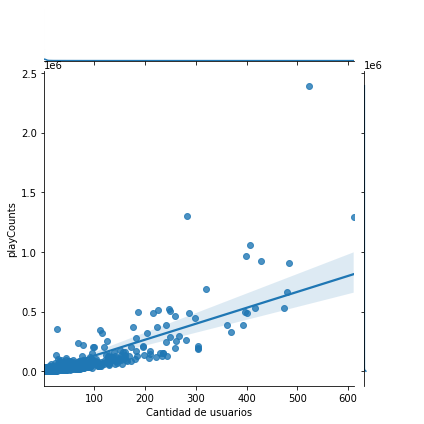

In [ ]:
# Distribución conjunta de cantidad de usuarios vs número de reproducciones
# Union de los datasets
ds_artist_plays_usrs = ds_artist_plays
ds_artist_plays_usrs['users'] = 1
ds_artist_plays_usrs = ds_artist_plays_usrs.groupby(['artistName','artistID']).sum().reset_index().sort_values(by='playCounts',ascending=False)
ds_artist_plays_usrs.drop(columns='userID')
g = seaborn.jointplot(data=ds_artist_plays_usrs,x='users',y='playCounts', kind='reg')
g.ax_joint.set_xlabel('Cantidad de usuarios')

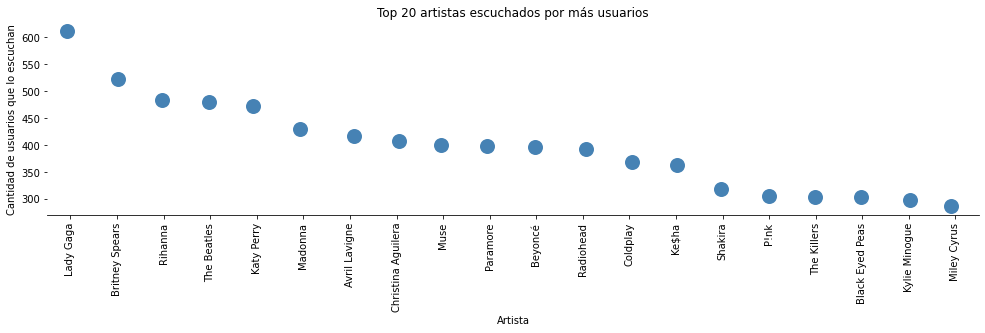

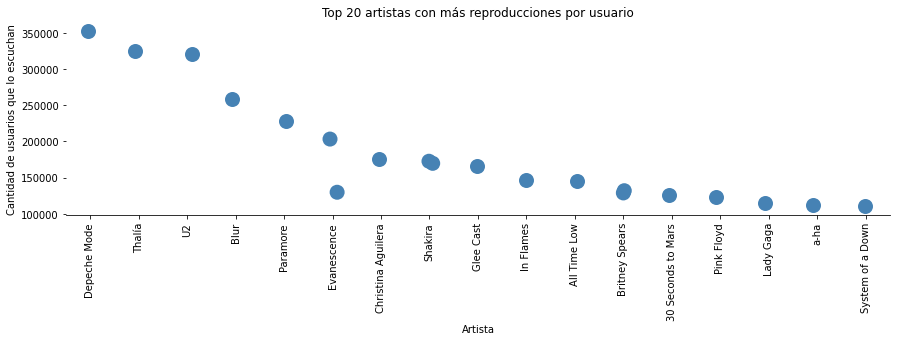

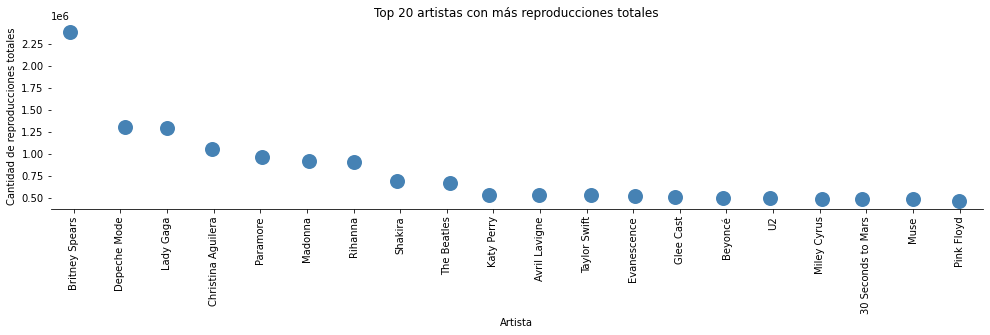

In [ ]:
g = seaborn.catplot(x='artista',y='oyentes', data=ds_art_usr.head(20),s=15,color='steelblue')
g.fig.set_figwidth(16)
g.fig.set_figheight(3)

plt.ylabel('Cantidad de usuarios que lo escuchan')
plt.xlabel('Artista')
plt.title('Top 20 artistas escuchados por más usuarios')
plt.xticks(rotation=90)
seaborn.despine(left=True)


g = seaborn.catplot(x='artistName',y='playCounts', data=ds_artist_plays_group.head(20),s=15,color='steelblue')
g.fig.set_figwidth(16)
g.fig.set_figheight(3)

plt.ylabel('Cantidad de usuarios que lo escuchan')
plt.xlabel('Artista')
plt.title('Top 20 artistas con más reproducciones por usuario')
plt.xticks(rotation=90)
seaborn.despine(left=True)

g = seaborn.catplot(x='artistName',y='playCounts', data=ds_art_rep.head(20),s=15,color='steelblue')
g.fig.set_figwidth(16)
g.fig.set_figheight(3)

plt.ylabel('Cantidad de reproducciones totales')
plt.xlabel('Artista')
plt.title('Top 20 artistas con más reproducciones totales')
plt.xticks(rotation=90)
seaborn.despine(left=True)

In [ ]:
# analicemos cuantos artistas escuchan los usuarios
ds_usr = ds_artist_plays_group.userID.value_counts().rename_axis(["userID"]).rename('oyentes').reset_index()
display(ds_usr.head(10))

,userID,oyentes
0,2047,50
1,1749,50
2,917,50
3,981,50
4,1109,50
5,1173,50
6,1237,50
7,1301,50
8,1365,50
9,1429,50


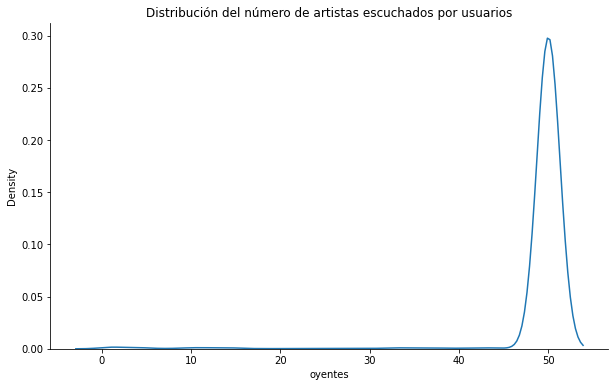

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Distribución del número de artistas escuchados por usuarios')
seaborn.kdeplot(ds_usr.oyentes)
seaborn.despine()

In [ ]:
# veamos los datos descriptivos de este dataset y cuantos usuarios con menos de 50 artistas hay
print(ds_usr.describe())
print('\n Hay %d usuarios con menos de 50 artistas en sus playlistst' % len(ds_usr[ds_usr.oyentes<50]))

            userID      oyentes
count  1892.000000  1892.000000
mean   1038.433404    49.066596
std     610.409730     5.845879
min       2.000000     1.000000
25%     505.500000    50.000000
50%    1031.000000    50.000000
75%    1572.250000    50.000000
max    2100.000000    50.000000

 Hay 63 usuarios con menos de 50 artistas en sus playlistst


In [ ]:
# veamos la cantidad de listens que tiene cada usuario
ds_usr_rep = ds_artist_plays_group.groupby(['userID'])['playCounts'].sum().reset_index().sort_values(by='playCounts',ascending=False)
display(ds_usr_rep.head(10))

,userID,playCounts
705,757,480039
1802,2000,468409
1280,1418,416349
1482,1642,388251
1002,1094,379125
1751,1942,348527
1867,2071,338400
1830,2031,329980
481,514,329782
361,387,322661


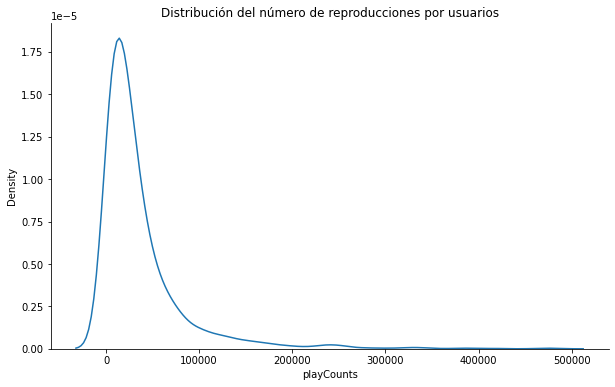

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Distribución del número de reproducciones por usuarios')
seaborn.kdeplot(ds_usr_rep.playCounts)
seaborn.despine()

In [ ]:
# hacemos un análisis descriptivo de este dataset
ds_usr_rep.describe()

,userID,playCounts
count,1892.000000,1892.000000
mean,1038.433404,36566.582981
std,610.409730,48744.552394
min,2.000000,3.000000
25%,505.500000,9742.250000
50%,1031.000000,21573.000000
75%,1572.250000,42963.750000
max,2100.000000,480039.000000


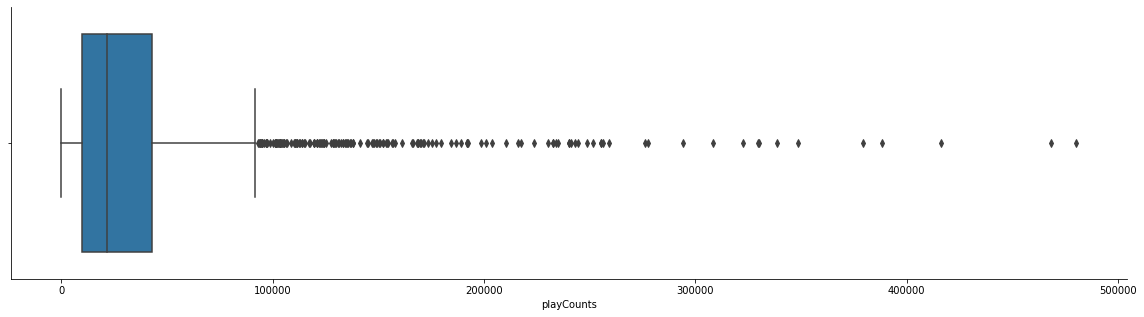

In [ ]:
plt.figure(figsize=(20,5))
seaborn.boxplot(x=ds_usr_rep.playCounts)
seaborn.despine()

In [ ]:
# tags
tags = pd.read_csv(DS_FILEPATH + "tags.dat", sep="\t", encoding = "ISO-8859-1")
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB


In [ ]:
print("Hay etiquetas duplicadas? " + str(tags.duplicated(subset=['tagValue']).any()))

Hay etiquetas duplicadas? False


In [ ]:
print('Ahora si habrá repetidos')
print("Hay etiquetas duplicadas? " + str(tags.duplicated(subset=['tagValue']).any()))

Ahora si habrá repetidos
Hay etiquetas duplicadas? False


In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB


In [ ]:
# user tagged artists

def dateparse (time_in_secs):    
    return dt.datetime.fromtimestamp(int(time_in_secs)/1000).strftime('%Y-%m-%d %H:%M:%S')

user_taggedartists_timestamps = pd.read_csv(DS_FILEPATH + "user_taggedartists-timestamps.dat", 
                                            sep="\t", parse_dates=['timestamp'],
                                            date_parser=dateparse)
user_taggedartists_timestamps.head()

,userID,artistID,tagID,timestamp
0,2,52,13,2009-03-31 22:00:00
1,2,52,15,2009-03-31 22:00:00
2,2,52,18,2009-03-31 22:00:00
3,2,52,21,2009-03-31 22:00:00
4,2,52,41,2009-03-31 22:00:00


In [ ]:
user_taggedartists_timestamps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userID     186479 non-null  int64         
 1   artistID   186479 non-null  int64         
 2   tagID      186479 non-null  int64         
 3   timestamp  186479 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.7 MB


In [ ]:
# Agrupamos por usuario, artista y tag para ver si los usuarios ponen mas de un tag a cada artista.
# Luego vizualizamos los primeros 20 registros del usuario id = 2 y vemos como asigna varias etiquetas a cada artista.

user_taggedartists_timestamps.groupby(['userID','artistID','tagID']).sum() \
.reset_index().sort_values(by='userID',ascending=True)[user_taggedartists_timestamps.userID == 2].head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,userID,artistID,tagID
0,2,52,13
25,2,96,19
26,2,96,24
27,2,995,16
28,2,995,17
29,2,995,24
30,2,995,25
31,2,995,42
32,2,995,43
33,2,3894,16


In [ ]:
# user friends
#user_friends = pd.read_csv(DS_FILEPATH + "user_friends.dat", sep="\t")
#user_friends.head()

In [ ]:
# Union de los datasets
ds_users_tags = pd.merge(tags, user_taggedartists_timestamps,
                        how="inner",
                        left_on="tagID",
                        right_on="tagID")

del ds_users_tags['tagID']
del ds_users_tags['timestamp']

ds_users_tags

,tagValue,userID,artistID
0,metal,4,918
1,metal,12,181
2,metal,12,198
3,metal,12,500
4,metal,12,503
...,...,...,...
186474,eire,2096,166
186475,eire,2096,389
186476,eire,2096,511
186477,eire,2096,1375


In [ ]:
# 10 tags mas populares. Esto nos da una idea de cuales son los generos mas escuchados.

ds_users_tags["tagValue"].value_counts().rename_axis(["tag"]).rename('cantidad').sort_values(ascending=False).reset_index().head(10)

,tag,cantidad
0,rock,7503
1,pop,5418
2,alternative,5251
3,electronic,4672
4,indie,4458
5,female vocalists,4228
6,80s,2791
7,dance,2739
8,alternative rock,2631
9,classic rock,2287


In [ ]:
ds_users_tags

,tagValue,userID,artistID
0,metal,4,918
1,metal,12,181
2,metal,12,198
3,metal,12,500
4,metal,12,503
...,...,...,...
186474,eire,2096,166
186475,eire,2096,389
186476,eire,2096,511
186477,eire,2096,1375


In [ ]:
# falta agrupar los tags por cada artista si queremos clasificar a los artistas en generos.

#ds_users_tags_artists_plays = pd.merge(ds_users_tags, ds_artist_plays,
#                                      how="inner",
#                                      left_on="userID",
#                                      right_on="userID")
#
#ds_users_tags_artists_plays

# Respuestas Ejercicio 1

**¿Cuáles son los artistas que fueron más escuchados?**

Depende que consideremos como los artistas más escuchados, pero extraimos la siguiente información al respecto:

- Lady Gaga es la artista más escuchada por cantidad de usuarios únicos (611).

- Britney Spears es la artista que acumula mas reproducciones (2393140).

- Depeche Mode es el artista más esuchado por un único usuario  con 352698 reproducciones.

**¿Cómo es la distribución de cantidad de listens por user?**

Observamos que la media es de aproximadamente 36500 reproducciones por usuario.
Mientras que el 50% de los usuarios reprodujeron aprox 21500 temas.

**¿Es posible ver el género más escuchado?**

Contando los tags que usan los usuarios podemos pensar que los géneros más escuchados son:
1. Rock
2. Pop
3. Alternative
4. Electronic
5. Indie


## Ejercicio 2 - Sistema de Recomendación

### Ejercicio 2a - Filtrados Colaborativos

Esta parte del ejercicio es obligatoria para aprobar la parte introductoria de la materia (i.e. los contenidos que se ven en las dos primeras clases), quienes estén realizando la materia completa deerán realizar también el [Ejercicio 2b](#Ejercicio-2b---Sistemas-de-Recomendación-Avanzados). 

Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [ ]:
# cambiamos el nombre para que quede más compacto
ds = ds_artist_plays

In [ ]:
# construimos la matriz de Usuario-Contenido.
# esta matriz tiene por sus filas a los usuarios, sus columnas los artistas y
# como valores las reproducciones del par (usuario, artista)
# completamos con 0 los ratings faltantes

matrix_user_content = ds.pivot_table(index = 'userID', columns = 'artistID', values = 'playCounts').fillna(0)
matrix_user_content

artistID,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,34,36,37,38,39,40,41,43,44,45,...,18696,18697,18698,18706,18707,18708,18709,18710,18711,18712,18713,18714,18715,18716,18717,18718,18719,18720,18721,18722,18723,18724,18725,18726,18727,18728,18729,18730,18734,18735,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1288.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Sparsity de la matriz
n_total = matrix_user_content.shape[0]*matrix_user_content.shape[1]
n_nonull = np.count_nonzero(matrix_user_content)
sparsity = n_nonull/n_total
print(f"Sparsity de la matriz Usuario-Contenido: {round(sparsity*100,2)}%")

Sparsity de la matriz Usuario-Contenido: 0.28%


In [ ]:
# necesitamos definir un reader con su rating_scale


# DUDA: rating_scale debería ser (0,max(weight)) o (min(weight),max(weight))
# --> Me parece que (0,max(weight)) dado que 0 sería "fijo" el minimo rating posible. Aunque el profe en el notebook clase_2.ipynb usó min().

# como artist_plays_group será nuestro dataframe de trabajo, seleccionaremos las
# columnas userID, artistID y weight como las columnas user ids, item ids y ratings
# respectivamente.

In [ ]:
# reader = surprise.Reader(rating_scale = (0,ds.weight.max()))
# data = surprise.Dataset.load_from_df(ds[['userID', 'artistID', 'weight']], reader)

# # iteramos sobre los siguientes algoritmos de predicción para hacer un benchmark 
# # comparando el RMSE y los tiempos de ejecución en los conjuntos training-test

# benchmark = []

# # (estos son muchos algoritmos, elegir algunos principales)

# algorithms_list = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

# for algo in algorithms_list:
#     # usando cross validation
#     results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)    
#     # guardamos el resultado
#     tmp = pd.DataFrame.from_dict(results).mean(axis=0)
#     tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
#     benchmark.append(tmp)

# # Resultados del benchmark
# surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
# surprise_results

In [ ]:
# Tune algorithm parameters with GridSearchCV
#
#
#

In [ ]:
# # Sistema de recomendación simple.
# # dado que queremos ver los artistas más parecidos entrenaremos un modelo
# # que use una métrica de similitud (k-NN inspired algorithms)
# # volvemos a evaluar el benchmark comparando sólo los modelos que nos interesan
# # y elegimos el mejor

# benchmark = []
# algorithms_list = [KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]
# for algo in algorithms_list:
#     results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
#     tmp = pd.DataFrame.from_dict(results).mean(axis=0)
#     tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
#     benchmark.append(tmp)

# # Resultados del benchmark
# surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
# surprise_results

In [ ]:
# Entrenamos el modelo

# creo el reader y cargo los datos
reader = Reader(rating_scale = (0,ds.playCounts.max()))
data = Dataset.load_from_df(ds[['userID', 'artistID', 'playCounts']], reader)

# defino conjunto de entrenamiento y entreno el modelo
trainset = data.build_full_trainset()
sim_options = {'name': 'msd', 'user_based': False}
algo = KNNWithZScore(sim_options=sim_options)
algo.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
# Con el modelo entrenado calculamos los vecinos de un artista dado

# pido ingresar el nombre de un artista
artist_name = input('Ingrese el nombre de un artista:\n')
done = False
while not done:    
    if len(ds[ds['artistName'].str.lower()==artist_name.lower()])==0:
        print('No se encuentra el artista.\nIntente nuevamente.')
        artist_name = input('Ingrese el nombre de un artista:\n')
    else:
        # busco el raw_id (artistID) dado el nombre del artista
        raw_id = ds[ds['artistName'].str.lower()==artist_name.lower()]['artistID'].iloc[0]
        # recupero el inner_id desde le raw_id
        inner_id = algo.trainset.to_inner_iid(raw_id)
        # obtengo los inner_id's de los vecinos que me dio el modelo
        # k=10 es la cantidad de vecinos a obtener
        neighbors = algo.get_neighbors(inner_id, k=10)
        # convierto los id internos a los artistID y así obtengo los nombre
        neighbors = (algo.trainset.to_raw_iid(inner_id)
                           for inner_id in neighbors)
        # creo la lista con los artistas encontrados
        lista_artistas = []
        for art in neighbors:
            lista_artistas.append(ds[ds['artistID']==art]['artistName'].iloc[0])
        # imprimo el pantalla los nombres de los artistas
        print('Los 10 artistas recomendados son:\n'+', '.join(lista_artistas[:-1])+' y '+lista_artistas[-1]+'.')
        done = True

Ingrese el nombre de un artista:
Queen
Los 10 artistas recomendados son:
Daniel Merriweather, Exposé, Klein & Mbo, Пикник, Suzanne Vega, Plastiscines, Chris Daughtry, QUEST PISTOLs, Further From The Truth y Rick Springfield.


### Ejercicio 2b - Sistemas de Recomendación Avanzados

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.

1. **Evaluación sobre cold start**

In [ ]:
# Completar... 

2. **Vectores de contenido**

In [ ]:
# Preparamos los vectores de contenido
# TODO: como mejora tratar de normalizar los Tags hay algunos que figuran algunos con diferentes nombres o nombres del tipo "better than lady gaga"

# 1. Quitamos la comuna userID
# 2. Agrupamos y cuentamos los tags de generos de cada artista
ds_genres = ds_users_tags.drop('userID', axis=1).groupby(['artistID'])['tagValue'].value_counts().rename('tagRating').reset_index()

# Observamos un artista en particular como quedaron organizados los tags de generos
ds_genres[ds_genres.artistID == 1]

,artistID,tagValue,tagRating
0,1,j-rock,5
1,1,visual kei,3
2,1,gothic,2
3,1,japanese,2
4,1,better than lady gaga,1
5,1,jrock,1
6,1,weeabo,1


In [ ]:
# Armamos la matriz
ds_matrix_artist_content = ds_genres.pivot(index='artistID', columns='tagValue', values='tagRating').fillna(0)
ds_matrix_artist_content

# TODO: Faltaria normalizar los ratings o limitar la cantidad de generos para un artista

tagValue,'80s,-pearl fashion music,0 play yet,00,00's,007,00s,00s rock,1,1008,10101,10s,111,112,12 stones,1200 micrograms,1200 mics,1337,1337 guitar players,1488,18 hits,1900,1900s,1940s,1950s,1960's,1960s,1963,1964,1965,1966,1967,1968,1969,1970,1970's,1970s,1971,1973,1974,...,yo la tengo,yorkshire,yoshimi,you,you are welcome in poland,you make me smile,young,young diva,young money,your ears will bleed,your imagination goes here,youth,youtube,yui,yui - life,yumiko,yurena,zac efron,zach galifianakis,zadrotstvo,zajebiste,zakk,zakk wylde,zaragoza,zard - hero,zen,zeppelin,zero 7,zeuhl,ziggyesque,zikirli,zmiel pierogi,zmierzch,zombie,zombie rave,zombieland,zoocore,zornish,ztt,zu
artistID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3. **Sistema de recomendación**

In [ ]:
cosine_sim = cosine_similarity(ds_matrix_artist_content, ds_matrix_artist_content)
cosine_sim

array([[1.        , 0.13333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13333333, 1.        , 0.        , ..., 0.06324555, 0.        ,
        0.02390457],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.06324555, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.02390457, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
def artist_finder(name):
  # buscamos ignorando mayusculas/minusculas
  return ds_artist_data[ds_artist_data['name'].str.contains('(?i)'+name)]['name'].tolist()

artist_idx = dict(zip(ds_artist_data['name'], list(ds_artist_data.index)))

In [ ]:
n_recommendations = 5

def rec_artist(input_name):
  name = artist_finder(input_name)[0]
  idx = artist_idx[name]

  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:(n_recommendations+1)]
  similar_artist = [i[0] for i in sim_scores]

  print("Recomendaciones para {}:".format(name))
  for artist in ds_artist_data['name'].iloc[similar_artist]:
    print("\t{}".format(artist))  



4. **Evaluación del sistema**

In [ ]:
rec_artist('metallica')

Recomendaciones para Metallica:
	Sister Rosetta Tharpe
	Stan Marsh
	The Templars
	Black Label Society
	Dead Silence Hides My Cries


In [ ]:
rec_artist('Megadeth')

Recomendaciones para Megadeth:
	Now
	Ángeles del Infierno
	Art of Dying
	Rosaline
	Third Day


In [ ]:
rec_artist('Pantera')

Recomendaciones para Pantera:
	Arabesque
	Shellac
	Amusement Parks on Fire
	Evile
	8Ball & MJG


In [ ]:
rec_artist('rihanna')

Recomendaciones para Rihanna:
	Breakout
	Outworld
	Nick Drake
	Chaqueño Palavecino
	Ramones


In [ ]:
rec_artist('Beyoncé')

Recomendaciones para Beyoncé:
	Frakkur
	Pan.Thy.Monium
	Fu Manchu
	Şanışer
	Evil Conduct


In [ ]:
rec_artist('Ariana Grande')

Recomendaciones para Ariana Grande:
	Sevendust
	Tamlin
	Beangrowers
	Gisa Alves
	Loose Ends


# Ejercicio 2b - otro intento


In [ ]:
# tags
tags = pd.read_csv(DS_FILEPATH + "tags.dat", sep="\t", encoding = "ISO-8859-1")
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [ ]:
# user_tags
user_tags = pd.read_csv(DS_FILEPATH + "user_taggedartists-timestamps.dat", sep="\t")
user_tags.head()

,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


In [ ]:
# dataset con tags
ds_t = tags # columns: tagID, tagValue
# dataset con user-tags
ds_ut = user_tags.drop(columns = 'timestamp') # columns: userID, artistID, tagID

# unimos las tagID con las tagValue

user_tagid = pd.merge(ds_ut, ds_t,
                        how="left",
                        left_on=['tagID'],
                        right_on=['tagID'])

display(user_tagid)
print(user_tagid.info())

,userID,artistID,tagID,tagValue
0,2,52,13,chillout
1,2,52,15,downtempo
2,2,52,18,electronic
3,2,52,21,trip-hop
4,2,52,41,female vovalists
...,...,...,...,...
186474,2100,16437,4,black metal
186475,2100,16437,292,folk
186476,2100,16437,2087,depressive black metal
186477,2100,16437,2801,dark folk


<class 'pandas.core.frame.DataFrame'>
Int64Index: 186479 entries, 0 to 186478
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userID    186479 non-null  int64 
 1   artistID  186479 non-null  int64 
 2   tagID     186479 non-null  int64 
 3   tagValue  186479 non-null  object
dtypes: int64(3), object(1)
memory usage: 7.1+ MB
None


In [ ]:
# agrego columna con conteno de veces que aparecen las tags
tags_count = user_tagid['tagValue'].value_counts(ascending=True)
tags_count = pd.DataFrame(tags_count).reset_index()
tags_count.columns = ['tagValue','count']

ds_usr_tag = pd.merge(user_tagid, tags_count,
                        how="inner",
                        left_on=['tagValue'],
                        right_on=['tagValue'])

display(ds_usr_tag)

,userID,artistID,tagID,tagValue,count
0,2,52,13,chillout,1387
1,2,63,13,chillout,1387
2,2,73,13,chillout,1387
3,2,94,13,chillout,1387
4,2,6177,13,chillout,1387
...,...,...,...,...,...
186474,2096,1124,6027,20th century classical,1
186475,2096,7932,12645,symbiosis,4
186476,2096,8438,12645,symbiosis,4
186477,2096,13890,12645,symbiosis,4


In [ ]:
ds_usr_tag.describe()

,userID,artistID,tagID,count
count,186479.000000,186479.000000,186479.000000,186479.000000
mean,1035.600137,4375.845328,1439.582913,1501.094316
std,622.461272,4897.789595,2775.340279,1993.485898
min,2.000000,1.000000,1.000000,1.000000
25%,488.000000,686.000000,79.000000,71.000000
50%,1021.000000,2203.000000,195.000000,633.000000
75%,1624.000000,6714.000000,887.000000,1834.000000
max,2100.000000,18744.000000,12647.000000,7503.000000


In [ ]:
ds_usr_tag_sorted = ds_usr_tag.sort_values(by=['count'],ascending=False)
ds_usr_tag_sorted

,userID,artistID,tagID,tagValue,count
29785,645,683,73,rock,7503
31474,1191,3732,73,rock,7503
31472,1191,3398,73,rock,7503
31471,1191,3230,73,rock,7503
31470,1191,3113,73,rock,7503
...,...,...,...,...,...
171007,1041,928,6884,beyond,1
171008,1041,1338,6882,legacy,1
171011,1042,701,6886,song of 2010,1
171012,1044,615,6913,poetry reading,1


,userID,artistID,tagID,tagValue,count
29785,645,683,73,rock,7503
31474,1191,3732,73,rock,7503
31472,1191,3398,73,rock,7503
31471,1191,3230,73,rock,7503
31470,1191,3113,73,rock,7503
...,...,...,...,...,...
144837,608,15457,1356,50s,131
144836,608,15390,1356,50s,131
144835,608,13450,1356,50s,131
144834,608,10661,1356,50s,131


Cantidad de etiquetas únicas: 185


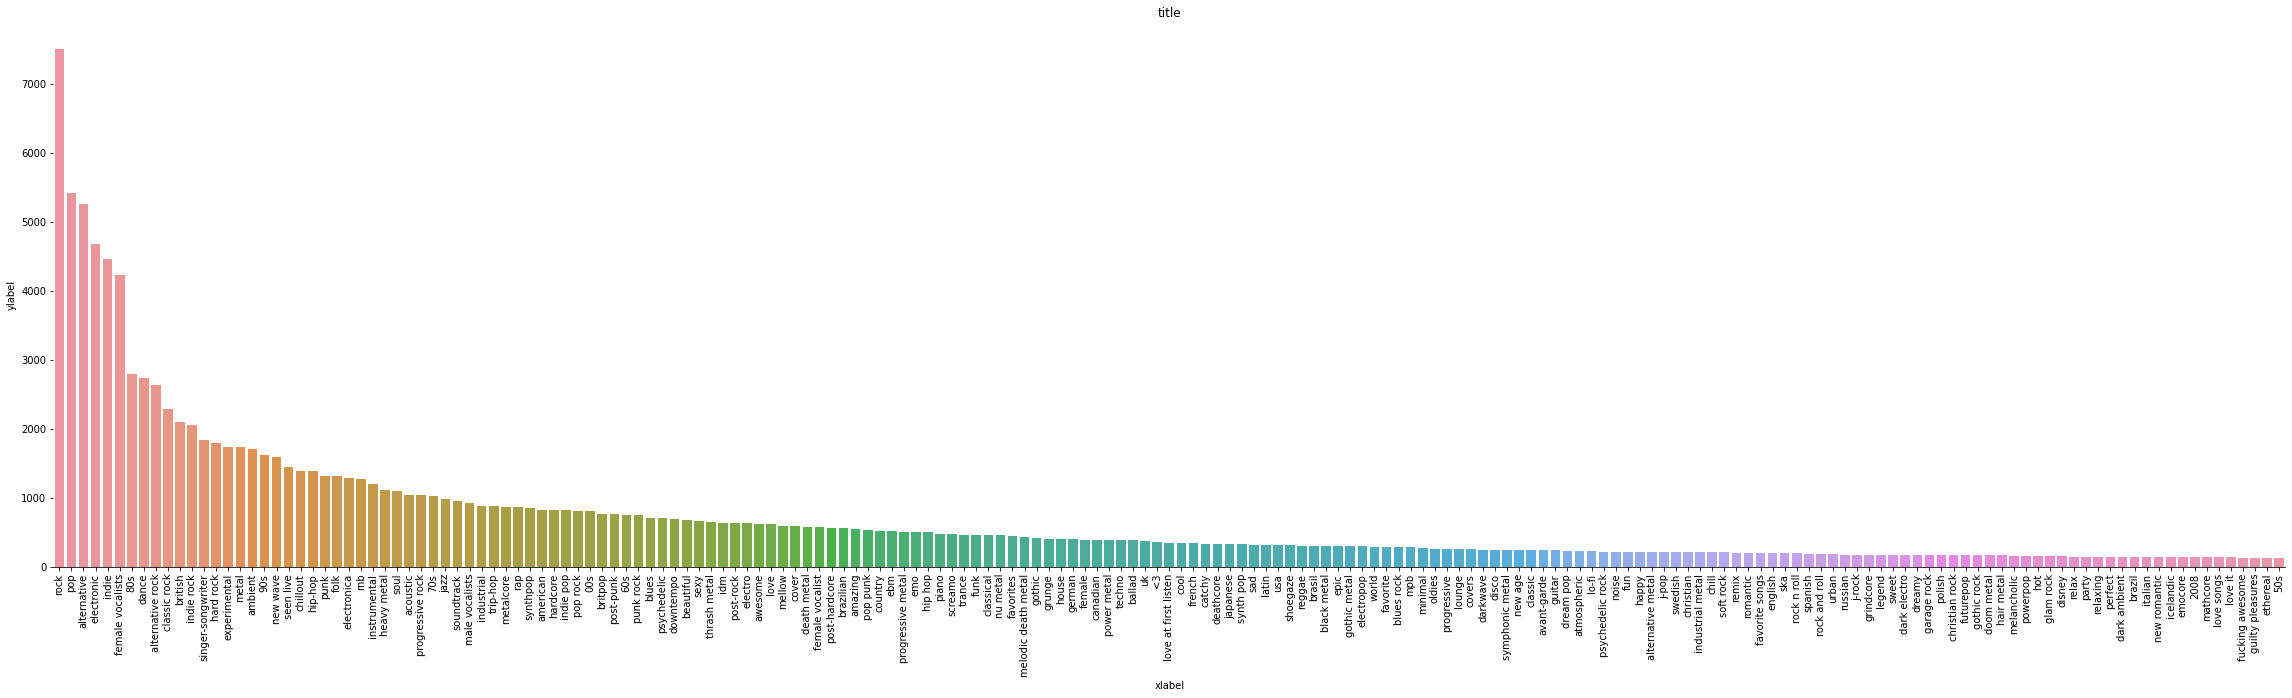

In [ ]:
ds_usr_tag_sorted = ds_usr_tag.sort_values(by=['count'],ascending=False)

# maximo = ds_usr_tag['count'].max()
# media = ds_usr_tag['count'].mean()
# mediana = ds_usr_tag['count'].median()
# desv = ds_usr_tag['count'].std()

# elijo quedarme con un subgrupo de etiqueras
# me quedo con el 70% más frecuente
threshold = ds_usr_tag['count'].quantile(q=0.3)

ds_usr_tag_sorted = ds_usr_tag_sorted[ds_usr_tag_sorted['count']>threshold]
display(ds_usr_tag_sorted)

print('Cantidad de etiquetas únicas: %d' % len(ds_usr_tag_sorted['tagID'].unique()))

plt.figure(figsize=(40,10))

g = seaborn.countplot(x="tagValue", data=ds_usr_tag_sorted, order=ds_usr_tag_sorted['tagValue'].value_counts().index)

plt.ylabel('ylabel')
plt.xlabel('xlabel')
plt.title('title')
plt.xticks(rotation=90)
seaborn.despine(left=True)

In [ ]:
print('Cantidad de etiqueras unicas:',len(ds_usr_tag['artistID'].unique()))
print('Cantidad de etiqueras unicas más frecuentes:',len(ds_usr_tag_sorted['artistID'].unique()))

Cantidad de etiqueras unicas: 12523
Cantidad de etiqueras unicas más frecuentes: 11065


In [ ]:
# agrupo las etiquetas para tener en un única entrada por par usuario-artista
taggroup = ds_usr_tag_sorted
taggroup['userID'] = taggroup['userID'].astype(str)
taggroup['tagID'] = taggroup['tagID'].astype(str)
ds_taggroup = taggroup.groupby(['artistID'])[['userID','tagID','tagValue']].agg(','.join).reset_index()
ds_taggroup['tagValue'] = ds_taggroup.tagValue.apply(lambda x: x.split(","))

display(ds_taggroup.sample(10))

,artistID,userID,tagID,tagValue
2700,3351,"926,2030","850,67","[cover, noise]"
7520,11040,921,195,[british]
1699,1965,"447,447,919,1152,544,1907,1557,447,357,447,447...","73,79,18,18,18,18,18,18,18,81,33,33,33,33,33,3...","[rock, alternative, electronic, electronic, el..."
10863,18300,190,850,[cover]
9511,15161,1848,78,[alternative rock]
4904,6579,"1792,406,860,546,1792","387,387,387,387,210","[progressive rock, progressive rock, progressi..."
8285,12461,"1854,1121","299,299","[world, world]"
3235,4055,1710,545,[classical]
2178,2626,"102,102,608,699,102","134,352,184,184,216","[singer-songwriter, 90s, soundtrack, soundtrac..."
174,208,"1433,298,1931,545,609,298,1694,1931,1433,2030,...","73,73,73,79,79,79,79,79,79,81,81,81,81,81,81,8...","[rock, rock, rock, alternative, alternative, a..."


In [ ]:
# Union de los datasets

ds_artist_data.columns = ['artistID','artistName']
ds_full = pd.merge(ds_taggroup, ds_artist_data,
                        how="left",
                        on=['artistID'])

ds_full

,artistID,userID,tagID,tagValue,artistName
0,1,"1545,1730,1545,1730,1984,1545,681,1730,1929","179,179,541,541,139,139,139,139,139","[gothic, gothic, japanese, japanese, j-rock, j...",MALICE MIZER
1,2,"1454,697,1454,40,225,1454,1679,1929,325,935,40...","18,14,127,127,61,179,179,179,179,179,30,30,30,...","[electronic, ambient, seen live, seen live, in...",Diary of Dreams
2,3,"548,63,685","4,4,4","[black metal, black metal, black metal]",Carpathian Forest
3,4,"1545,699,1545,1545,1679,1730,1545,1679,1730,19...","73,1,1,179,179,179,541,541,541,541,7,139,139,1...","[rock, metal, metal, gothic, gothic, gothic, j...",Moi dix Mois
4,5,"557,2055,935,557,1774,557","179,1097,575,575,575,190","[gothic, covers, darkwave, darkwave, darkwave,...",Bella Morte
...,...,...,...,...,...
11060,18737,"454,1958,454,2030","79,25,187,67","[alternative, 80s, electronica, noise]",Ciccone Youth
11061,18739,"1879,1879,1879,1879,1879,1879,2096,1700","73,79,18,78,187,21,121,370","[rock, alternative, electronic, alternative ro...",Apollo 440
11062,18740,"1929,1929","61,86","[industrial, ebm]",Die Krupps
11063,18741,1700,33,[experimental],Diamanda Galás


In [ ]:
ds_full['userID'] = ds_full['userID'].astype(str)
ds_full['tagID'] = ds_full['tagID'].astype(str)
#ds_full['tagValue'] = ds_full['tagValue'].astype(str)
print(ds_full.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11065 entries, 0 to 11064
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artistID    11065 non-null  int64 
 1   userID      11065 non-null  object
 2   tagID       11065 non-null  object
 3   tagValue    11065 non-null  object
 4   artistName  10743 non-null  object
dtypes: int64(1), object(4)
memory usage: 518.7+ KB
None


In [ ]:
ds_full = ds_full.dropna(subset=['artistName'])

In [ ]:
ds_full.reset_index(drop=True, inplace=True)
ds_full

,artistID,userID,tagID,tagValue,artistName
0,1,"1545,1730,1545,1730,1984,1545,681,1730,1929","179,179,541,541,139,139,139,139,139","[gothic, gothic, japanese, japanese, j-rock, j...",MALICE MIZER
1,2,"1454,697,1454,40,225,1454,1679,1929,325,935,40...","18,14,127,127,61,179,179,179,179,179,30,30,30,...","[electronic, ambient, seen live, seen live, in...",Diary of Dreams
2,3,"548,63,685","4,4,4","[black metal, black metal, black metal]",Carpathian Forest
3,4,"1545,699,1545,1545,1679,1730,1545,1679,1730,19...","73,1,1,179,179,179,541,541,541,541,7,139,139,1...","[rock, metal, metal, gothic, gothic, gothic, j...",Moi dix Mois
4,5,"557,2055,935,557,1774,557","179,1097,575,575,575,190","[gothic, covers, darkwave, darkwave, darkwave,...",Bella Morte
...,...,...,...,...,...
10738,18737,"454,1958,454,2030","79,25,187,67","[alternative, 80s, electronica, noise]",Ciccone Youth
10739,18739,"1879,1879,1879,1879,1879,1879,2096,1700","73,79,18,78,187,21,121,370","[rock, alternative, electronic, alternative ro...",Apollo 440
10740,18740,"1929,1929","61,86","[industrial, ebm]",Die Krupps
10741,18741,1700,33,[experimental],Diamanda Galás


In [ ]:
# vectores de contendio según género
genres = set(g for G in ds_full['tagValue'] for g in G)
print(len(genres))

185


In [ ]:
genres

{'00s',
 '2008',
 '50s',
 '60s',
 '70s',
 '80s',
 '90s',
 '<3',
 'acoustic',
 'alternative',
 'alternative metal',
 'alternative rock',
 'amazing',
 'ambient',
 'american',
 'atmospheric',
 'avant-garde',
 'awesome',
 'ballad',
 'beautiful',
 'black metal',
 'blues',
 'blues rock',
 'brasil',
 'brazil',
 'brazilian',
 'british',
 'britpop',
 'canadian',
 'catchy',
 'chill',
 'chillout',
 'christian',
 'christian rock',
 'classic',
 'classic rock',
 'classical',
 'cool',
 'country',
 'cover',
 'covers',
 'dance',
 'dark ambient',
 'dark electro',
 'darkwave',
 'death metal',
 'deathcore',
 'disco',
 'disney',
 'doom metal',
 'downtempo',
 'dream pop',
 'dreamy',
 'ebm',
 'electro',
 'electronic',
 'electronica',
 'electropop',
 'emo',
 'emocore',
 'english',
 'epic',
 'ethereal',
 'experimental',
 'favorite',
 'favorite songs',
 'favorites',
 'female',
 'female vocalist',
 'female vocalists',
 'folk',
 'french',
 'fucking awesome',
 'fun',
 'funk',
 'futurepop',
 'garage rock',
 'german

In [ ]:
ds_full_exp = ds_full.copy()
for g in genres:
    ds_full_exp[g] = ds_full_exp.tagValue.transform(lambda x: int(g in x))
    
ds_full_genres = ds_full_exp.drop(columns=['userID','artistID','artistName','tagID','tagValue'])
ds_full_genres

,love at first listen,country,synth pop,rock n roll,favorite,urban,pop punk,progressive metal,beautiful,metal,british,dark electro,blues,covers,psychedelic,acoustic,uk,christian,electropop,80s,noise,rnb,classical,male vocalists,reggae,melodic death metal,pop,gothic,j-pop,alternative rock,soundtrack,dream pop,remix,dark ambient,post-hardcore,relaxing,nu metal,funk,ethereal,disco,...,glam rock,happy,powerpop,hot,mathcore,avant-garde,awesome,swedish,english,new age,60s,downtempo,industrial metal,latin,alternative metal,gothic rock,sweet,darkwave,hardcore,hard rock,ebm,classic,electronic,brazilian,deathcore,female vocalist,hair metal,german,singer-songwriter,indie pop,usa,thrash metal,mellow,soft rock,seen live,canadian,heavy metal,metalcore,dance,shoegaze
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10738,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10739,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10741,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cosine_sim = cosine_similarity(ds_full_genres,ds_full_genres)

In [ ]:
#ds_full.iloc[[827]]

In [ ]:
def artist_finder(name):
    return ds_full[ds_full['artistName'] == name ]['artistName'].tolist()

# pido ingresar el nombre de un artista
artist_name = input('Ingrese el nombre de un artista:\n')
done = False
while not done:    
    if len(ds_full[ds_full['artistName']==artist_name])==0:
        print('No se encuentra el artista.\nIntente nuevamente.')
        artist_name = input('Ingrese el nombre de un artista:\n')
    else:
        artist_idx = dict(zip(ds_full['artistName'], list(ds_full.index)))
        name = artist_finder(artist_name)[0]
        n_recommendations = 5

        idx = artist_idx[name]
        print('idx', idx)

        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:(n_recommendations+1)]
        similar_artists = [i[0] for i in sim_scores]
        if idx in similar_artists:
            similar_artists.remove(idx) 

        print("Recomendaciones para {}:".format(name))
        for artist in ds_full['artistName'].iloc[similar_artists[0:n_recommendations]]:
            print("\t{}".format(artist))
            done = True

Ingrese el nombre de un artista:
Queen
idx 827
Recomendaciones para Queen:
	Paul McCartney
	Michael Jackson
	The Rolling Stones
	KISS
	The Beatles


# Ejercicio 2b - otro intento - con rating/pesos en los generos

In [ ]:
ds_artist_data = pd.read_csv(DS_FILEPATH + "artists.dat", sep="\t", usecols=['id','name'])

tags = pd.read_csv(DS_FILEPATH + "tags.dat", sep="\t", encoding = "ISO-8859-1")


#### Normalizacion de algunos tags. Se podrian normalizar los años/decadas.
genres_normalize_dict = {
    'brasil': 'brazilian',
    'brazil': 'brazilian',
    'chill': 'chillout',
    'cover': 'covers',
    'electronic': 'electro',
    'electronica': 'electro',
    'favorite songs' : 'favorite',
    'favorites' : 'favorite',
    'female' : 'female vocalist',
    'female vocalists': 'female vocalist',
    'fucking awesome': 'awesome',
    'love at first listen': 'love songs',
    'love it': 'love songs',
    'relaxing': 'relax',    
    'rock and roll': 'rock',
    'rock n roll': 'rock',
    'synthpop': 'synth pop',
    'christian rock': 'christian'
 }

tags.tagValue = tags.tagValue.str.replace('-', ' ')
tags.tagValue.replace(genres_normalize_dict, inplace=True)
#######


# user tagged artists

def dateparse (time_in_secs):    
    return dt.datetime.fromtimestamp(int(time_in_secs)/1000).strftime('%Y-%m-%d %H:%M:%S')

user_taggedartists_timestamps = pd.read_csv(DS_FILEPATH + "user_taggedartists-timestamps.dat", 
                                            sep="\t", parse_dates=['timestamp'],
                                            date_parser=dateparse)
user_taggedartists_timestamps.head()



# Union de los datasets
ds_users_tags = pd.merge(tags, user_taggedartists_timestamps,
                        how="inner",
                        left_on="tagID",
                        right_on="tagID")

del ds_users_tags['tagID']
del ds_users_tags['timestamp']


ds_artist_data.columns = ['artistID','artistName']
#ds_users_tags = pd.merge(ds_users_tags, ds_artist_data,
#                        how="left",
#                        on=['artistID'])
#ds_users_tags
#print('Hay %d artistas etiquetados y en total son %d artistas' %(len(ds_users_tags.artistID.unique()), len(ds_artist_data.id.unique())))

In [ ]:
# eliminamos las etiquetas menos frecuentes

# agrego columna con conteno de veces que aparecen las tags
tags_count = ds_users_tags['tagValue'].value_counts(ascending=True)
tags_count = pd.DataFrame(tags_count).reset_index()
tags_count.columns = ['tagValue','count']

ds_usr_tag = pd.merge(ds_users_tags, tags_count,
                        how="inner",
                        left_on=['tagValue'],
                        right_on=['tagValue'])

display(ds_usr_tag)

,tagValue,userID,artistID,count
0,metal,4,918,1729
1,metal,12,181,1729
2,metal,12,198,1729
3,metal,12,500,1729
4,metal,12,503,1729
...,...,...,...,...
186474,eire,2096,166,6
186475,eire,2096,389,6
186476,eire,2096,511,6
186477,eire,2096,1375,6


In [ ]:
ds_usr_tag_sorted = ds_usr_tag.sort_values(by=['count'],ascending=False)

# elijo quedarme con un subgrupo de etiqueras
# me quedo con el 70% más frecuente
threshold = ds_usr_tag['count'].quantile(q=0.3)

ds_usr_tag_sorted = ds_usr_tag_sorted[ds_usr_tag_sorted['count']>threshold]
display(ds_usr_tag_sorted)

,tagValue,userID,artistID,count
45226,rock,909,377,7886
47183,rock,1481,481,7886
47181,rock,1476,1034,7886
47180,rock,1469,154,7886
47179,rock,1466,17166,7886
...,...,...,...,...
133516,2008,387,6373,137
133523,2008,387,10768,137
133525,2008,387,18425,137
133526,2008,753,257,137


In [ ]:
# Preparamos los vectores de contenido probando asignar un peso/rating a los generos.

# Generamos un dataset contando los diferentes tags que tiene cada artistas, ordenamos y eliminamos los userID
ds_artist_genres = ds_usr_tag_sorted.drop('userID', axis=1).groupby(['artistID'])['tagValue'].value_counts().rename('tagRating').reset_index().sort_values(['artistID', 'tagRating'], ascending=[True, False])
ds_artist_genres.head(10)

,artistID,tagValue,tagRating
0,1,j rock,5
1,1,gothic,2
2,1,japanese,2
3,2,darkwave,8
4,2,german,5
5,2,gothic,5
6,2,seen live,2
7,2,ambient,1
8,2,electro,1
9,2,gothic rock,1


In [ ]:
# Dejamos solo los principales 5 tags mas etiquetados a cada artista
ds_principal_genres = ds_artist_genres.groupby(['artistID']).apply(lambda x: x[:7]).reset_index(drop=True)
ds_principal_genres

,artistID,tagValue,tagRating
0,1,j rock,5
1,1,gothic,2
2,1,japanese,2
3,2,darkwave,8
4,2,german,5
...,...,...,...
41889,18744,avant garde,1
41890,18744,chillout,1
41891,18744,dark ambient,1
41892,18744,dark electro,1


In [ ]:
print('Valores antes de normalizar')
print('Min:', ds_principal_genres.tagRating.min())
print('Max:', ds_principal_genres.tagRating.max())

Valores antes de normalizar
Min: 1
Max: 108


In [ ]:
# Normalizamos los tagRating

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()

col_names = ['tagRating']
features = ds_principal_genres[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

ds_principal_genres[col_names] = features
ds_principal_genres

,artistID,tagValue,tagRating
0,1,j rock,0.536475
1,1,gothic,-0.151720
2,1,japanese,-0.151720
3,2,darkwave,1.224670
4,2,german,0.536475
...,...,...,...
41889,18744,avant garde,-0.381119
41890,18744,chillout,-0.381119
41891,18744,dark ambient,-0.381119
41892,18744,dark electro,-0.381119


In [ ]:
print('Valores despues de normalizar')
print('Min:', ds_principal_genres.tagRating.min())
print('Max:', ds_principal_genres.tagRating.max())

Valores despues de normalizar
Min: -0.3811186935669384
Max: 24.164508740520944


In [ ]:
# Armamos la matriz
ds_matrix_artist_content = ds_principal_genres.pivot(index='artistID', columns='tagValue', values='tagRating').fillna(0).reset_index()
print(ds_matrix_artist_content.shape)
ds_matrix_artist_content

(11073, 163)


tagValue,artistID,00s,2008,60s,70s,80s,90s,<3,acoustic,alternative,alternative metal,alternative rock,amazing,ambient,american,atmospheric,avant garde,awesome,ballad,beautiful,black metal,blues,blues rock,brazilian,british,britpop,canadian,catchy,chillout,christian,classic,classic rock,classical,cool,country,covers,dance,dark ambient,dark electro,darkwave,...,power metal,powerpop,progressive,progressive metal,progressive rock,psychedelic,psychedelic rock,punk,punk rock,rap,reggae,relax,remix,rnb,rock,romantic,russian,sad,screamo,seen live,sexy,shoegaze,singer songwriter,ska,soft rock,soul,soundtrack,spanish,swedish,sweet,symphonic metal,synth pop,techno,thrash metal,trance,trip hop,uk,urban,usa,world
0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,-0.381119,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.224670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.15172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.077678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.381119,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.381119,0.0,0.000000,0.000000,0.077678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11068,18737,0.0,0.0,0.0,0.0,-0.381119,0.0,0.0,0.0,-0.381119,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
11069,18739,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.381119,0.0,-0.381119,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.381119,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.381119,-0.381119,0.0,0.0,0.0
11070,18740,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
#set(ds_matrix_artist_content.columns)

In [ ]:
# Armo la relacion indice - id de artista para la matriz de similitud (es un fix para el metodo que busca las recomensaciones, se podria mejorar esto)
indice_artistas = ds_matrix_artist_content[['artistID']]

idx_artists = pd.merge(indice_artistas, ds_artist_data,
                        how="left",
                        on=['artistID'])
idx_artists

,artistID,artistName
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte
...,...,...
11068,18737,Ciccone Youth
11069,18739,Apollo 440
11070,18740,Die Krupps
11071,18741,Diamanda Galás


In [ ]:
cosine_sim = cosine_similarity(ds_matrix_artist_content, ds_matrix_artist_content)
cosine_sim

array([[1.        , 0.64988591, 0.86556971, ..., 0.86585981, 0.86585981,
        0.86585981],
       [0.64988591, 1.        , 0.78214672, ..., 0.78240887, 0.78240887,
        0.7824119 ],
       [0.86556971, 0.78214672, 1.        , ..., 0.99966495, 0.99966495,
        0.99966495],
       ...,
       [0.86585981, 0.78240887, 0.99966495, ..., 1.        , 1.        ,
        1.        ],
       [0.86585981, 0.78240887, 0.99966495, ..., 1.        , 1.        ,
        1.        ],
       [0.86585981, 0.7824119 , 0.99966495, ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
def artist_finder(name):
  # buscamos ignorando mayusculas/minusculas
  #return ds_artist_data[ds_artist_data['name'].str.contains('(?i)'+name)]['name'].tolist()
  return idx_artists[idx_artists['artistName'] == name ]['artistName'].tolist()

In [ ]:
#artist_idx = dict(zip(ds_artist_data['artistName'], list(ds_artist_data.index)))

In [ ]:
n_recommendations = 5

def rec_artist(input_name):
  name = artist_finder(input_name)[0]
  artist_idx = dict(zip(idx_artists['artistName'], list(idx_artists.index)))
  idx = artist_idx[name]
  print('idx en idx_artists:',idx)
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:(n_recommendations+1)]
  similar_artist = [i[0] for i in sim_scores]

  print("Recomendaciones para {}:".format(name))
  for artist in idx_artists['artistName'].iloc[similar_artist]:
    print("\t{}".format(artist))  

In [ ]:
rec_artist('Queen')

idx en idx_artists: 832
Recomendaciones para Queen:
	Led Zeppelin
	The Who
	Guns N' Roses
	Bon Jovi
	The Rolling Stones


In [ ]:
# Referencia para comparar la recomendacion: https://www.last.fm/es/music/Queen/+similar?page=1

In [ ]:
def artist_finder(name):
    return idx_artists[idx_artists['artistName'] == name ]['artistName'].tolist()

# pido ingresar el nombre de un artista
artist_name = input('Ingrese el nombre de un artista:\n')
print(artist_name)

done = False
while not done:    
    if len(idx_artists[idx_artists['artistName']==artist_name])==0:
        print('No se encuentra el artista.\nIntente nuevamente.')
        artist_name = input('Ingrese el nombre de un artista:\n')
    else:
        artist_idx = dict(zip(idx_artists['artistName'], list(idx_artists.index)))
        name = artist_finder(artist_name)[0]
        n_recommendations = 5

        idx = artist_idx[name]
        print('idx en idx_artists:',idx)
        
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:(n_recommendations+1)]
        similar_artists = [i[0] for i in sim_scores]
        if idx in similar_artists:
            similar_artists.remove(idx) 

        print("Recomendaciones para {}:".format(name))
        for artist in idx_artists['artistName'].iloc[similar_artists[0:n_recommendations]]:
            print("\t{}".format(artist))
            done = True

Ingrese el nombre de un artista:
Queen
Queen
idx en idx_artists: 832
Recomendaciones para Queen:
	Led Zeppelin
	The Who
	Guns N' Roses
	Bon Jovi
	The Rolling Stones
